In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Defining constants
IMG_SHAPE = (28, 28, 1) # Image shape (grayscale images)
LATENT_DIM = 100 # Latent space dimension
NUM_EPOCHS = 6 # Number of epochs
BATCH_SIZE = 8 # Batch size
STEPS_PER_EPOCH = 100 # Steps per epoch

In [3]:
# Generating synthetic dataset
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1, 28, 28, 1)).astype('float32') / 255.0

In [4]:
# Defining the generator model
def build_generator(latent_dim):
    model_input = Input(shape=(latent_dim,))
    x = Dense(7 * 7 * 128)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 128))(x)
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(1, kernel_size=7, activation='sigmoid', padding='same')(x) # Output image
    generator = Model(model_input, x)
    return generator

In [5]:
# Defining the discriminator model
def build_discriminator(img_shape):
    model_input = Input(shape=img_shape)
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x) # Output probability
    discriminator = Model(model_input, x)
    return discriminator

In [6]:
# Defining the GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(LATENT_DIM,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return gan

In [7]:
# Build and compile the models
generator = build_generator(LATENT_DIM)
discriminator = build_discriminator(IMG_SHAPE)
gan = build_gan(generator, discriminator)

# Compile discriminator and generator
discriminator.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy')

In [8]:
# Training loop
for epoch in range(NUM_EPOCHS):
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS}')
    for step in range(STEPS_PER_EPOCH):
        # Training the discriminator
        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        generated_images = generator.predict(noise)
        real_images = x_train[np.random.randint(0, x_train.shape[0], BATCH_SIZE)]
        x = np.concatenate((real_images, generated_images))
        y = np.zeros(2 * BATCH_SIZE)
        y[:BATCH_SIZE] = 0.9 # Label smoothing
        discriminator_loss = discriminator.train_on_batch(x, y)

        # Training the generator
        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        y = np.ones(BATCH_SIZE)
        generator_loss = gan.train_on_batch(noise, y)

        # Printing progress
        if step % 10 == 0:
            print(f'Step: {step}/{STEPS_PER_EPOCH}, Discriminator Loss: {discriminator_loss}, Generator Loss: {generator_loss}')

Epoch: 1/6
1/1 [==============================] - 1s 1s/step
Step: 0/100, Discriminator Loss: 0.6929806470870972, Generator Loss: 0.6910165548324585
1/1 [==============================] - 0s 39ms/step
Step: 10/100, Discriminator Loss: 0.7352321147918701, Generator Loss: 0.6188216805458069
1/1 [==============================] - 0s 81ms/step
Step: 20/100, Discriminator Loss: 0.7552440166473389, Generator Loss: 0.5862026214599609
1/1 [==============================] - 0s 69ms/step
Step: 30/100, Discriminator Loss: 0.756087064743042, Generator Loss: 0.5815286636352539
1/1 [==============================] - 0s 18ms/step
Step: 40/100, Discriminator Loss: 0.7681239247322083, Generator Loss: 0.5806657075881958
1/1 [==============================] - 0s 30ms/step
Step: 50/100, Discriminator Loss: 0.7814010381698608, Generator Loss: 0.5526425242424011
1/1 [==============================] - 0s 16ms/step
Step: 60/100, Discriminator Loss: 0.7854670882225037, Generator Loss: 0.5395206212997437
1/1 [=

In [11]:
# Generating images using the trained generator
num_images = 10
noise = np.random.normal(0, 1, (num_images, LATENT_DIM))
generated_images = generator.predict(noise)

1/1 [==============================] - 0s 18ms/step


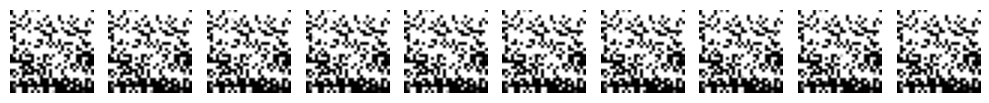

In [12]:
# Plotting the generated images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()